In [5]:
#Import Libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, learning_curve
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pickle

In [6]:
#Load and Inspect the Dataset
data = pd.read_csv('srilanka_vehicle_data.csv')
data.head()

,Brand,Model,Year,Condition,Transmission,Fuel,Capacity (cc),Mileage (Km),Price (Rs)
0,Honda,Vezel,2017,Used,Automatic,Hybrid,1500,37000,12900000
1,Jaguar,XF,2013,Used,Automatic,Diesel,2200,42000,16250000
2,Toyota,CHR,2020,Used,Automatic,Petrol,1200,15000,17000000
3,Toyota,CHR,2017,Used,Automatic,Petrol,1200,21000,13000000
4,Toyota,Land Cruiser Prado,2015,Used,Automatic,Petrol,2700,57000,33500000


In [7]:
#Check for Missing Values and Data Information

missing_values = data.isnull().sum()
print(missing_values)

Brand            0
Model            0
Year             0
Condition        0
Transmission     0
Fuel             0
Capacity (cc)    0
Mileage (Km)     0
Price (Rs)       0
dtype: int64


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110255 entries, 0 to 110254
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Brand          110255 non-null  object
 1   Model          110255 non-null  object
 2   Year           110255 non-null  int64 
 3   Condition      110255 non-null  object
 4   Transmission   110255 non-null  object
 5   Fuel           110255 non-null  object
 6   Capacity (cc)  110255 non-null  int64 
 7   Mileage (Km)   110255 non-null  int64 
 8   Price (Rs)     110255 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 7.6+ MB


In [9]:
#Convert Non-Numeric Values to Numeric

def convert_to_numeric(value):
    value = str(value)
    value = re.sub(r'[^\d.]', '', value)
    return pd.to_numeric(value, errors='coerce')

data['Year'] = data['Year'].apply(convert_to_numeric)
data['Capacity (cc)'] = data['Capacity (cc)'].apply(convert_to_numeric)
data['Mileage (Km)'] = data['Mileage (Km)'].apply(convert_to_numeric)
data['Price (Rs)'] = data['Price (Rs)'].apply(convert_to_numeric)

In [10]:
#Encode Categorical Variables

label_encoders = {}

categorical_columns = ['Brand', 'Model', 'Condition', 'Transmission', 'Fuel']

for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

In [11]:
#Prepare Input Data for Prediction

input_data = {
    'Brand': 'Toyota',
    'Model': 'Corolla',
    'Condition': 'Used',
    'Transmission': 'Automatic',
    'Fuel': 'Petrol',
    'Year': 2018,
    'Capacity (cc)': 1500,
    'Mileage (Km)': 30000
}

In [12]:
#Define Features and Target Variable

X = data.drop(columns=['Price (Rs)'])
y = data['Price (Rs)']

In [13]:
# Split the Data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
#Train the Model
model = RandomForestRegressor(random_state=42)
model.fit(x_train, y_train)


RandomForestRegressor(random_state=42)

In [15]:
# Compute the metrics
y_pred = model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = model.score(x_test, y_test)  # R-squared score

# Print the metrics in a formatted way
print(f"Mean Absolute Error (MAE): {mae:,.2f}")
print(f"Mean Squared Error (MSE): {mse:,.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")
print(f"R-squared (R²) Score: {r2:.4f}")

Mean Absolute Error (MAE): 1,179,974.94
Mean Squared Error (MSE): 52,215,221,985,327.43
Root Mean Squared Error (RMSE): 7,226,010.10
R-squared (R²) Score: 0.5981


In [16]:
#Calculate Accuracy Percentage
accuracy_percentage = 100*(1-(mae/y_test.mean()))
print(f"Accuracy Percentage: {accuracy_percentage:2f}%")


Accuracy Percentage: 82.829748%


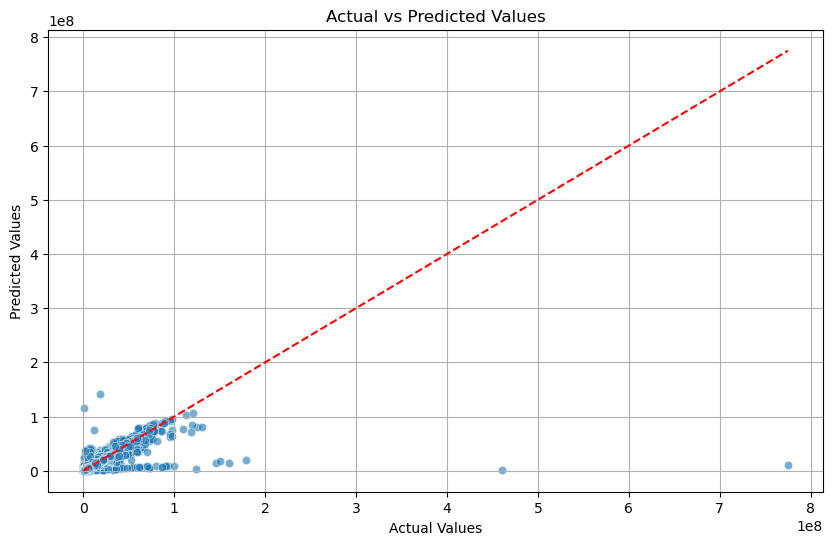

In [17]:
#Visualize Predictions
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=results_df, alpha=0.6)
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()],
         [results_df['Actual'].min(), results_df['Actual'].max()],
         color='red', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()


C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


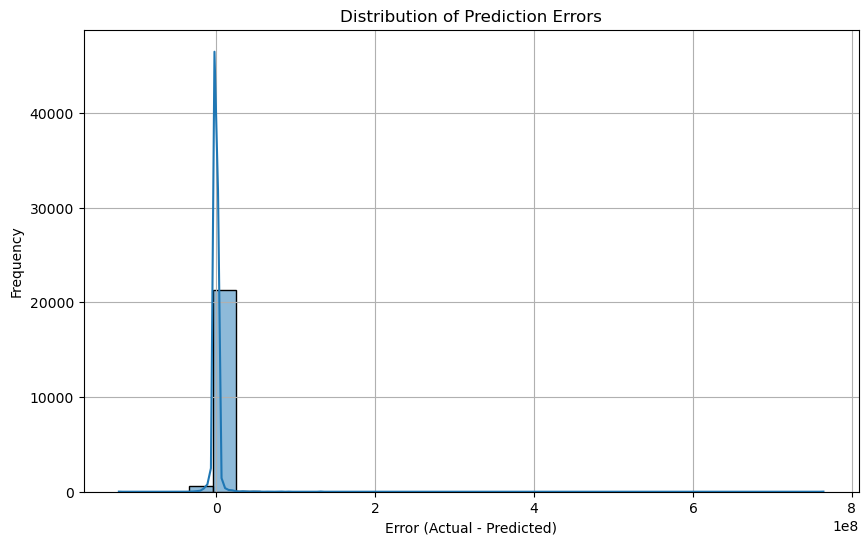

In [18]:
#Plot Distribution of Errors
errors = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=30)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


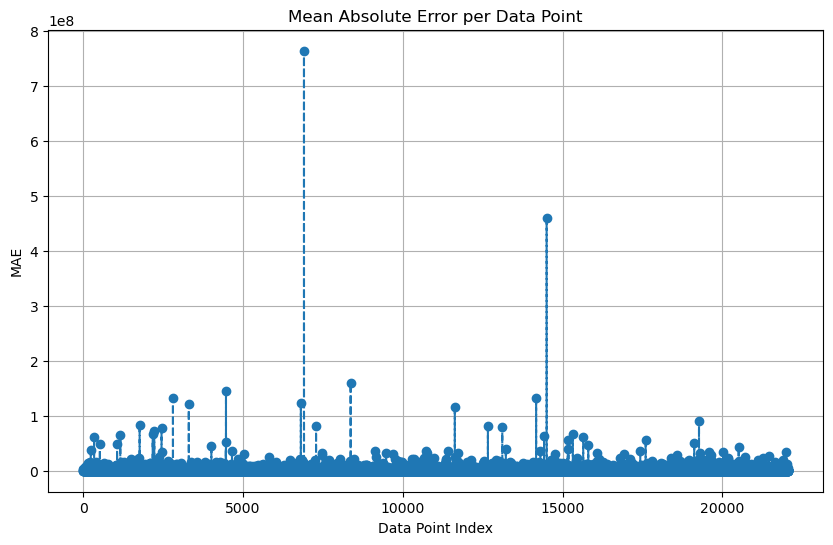

In [19]:
#Plot MAE for Each Data Point
mae_per_point = abs(errors)

plt.figure(figsize=(10, 6))
plt.plot(mae_per_point.values, marker='o', linestyle='--')
plt.title('Mean Absolute Error per Data Point')
plt.xlabel('Data Point Index')
plt.ylabel('MAE')
plt.grid(True)
plt.show()


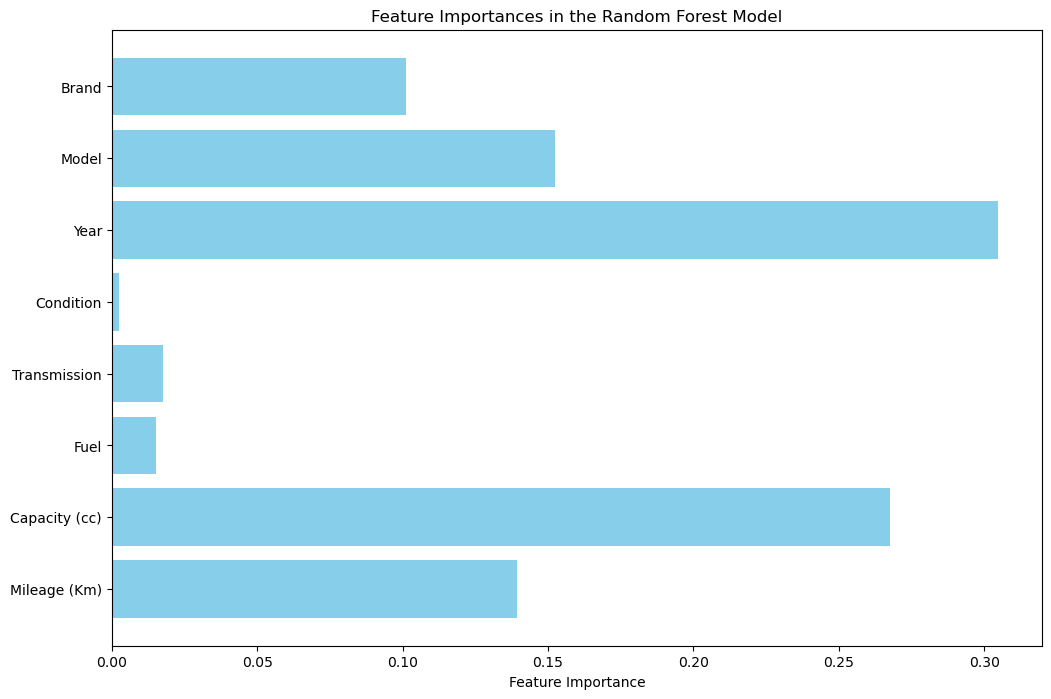

In [20]:
#Feature Importance Chart
# Plot feature importances
importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(12, 8))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances in the Random Forest Model')
plt.gca().invert_yaxis()
plt.show()


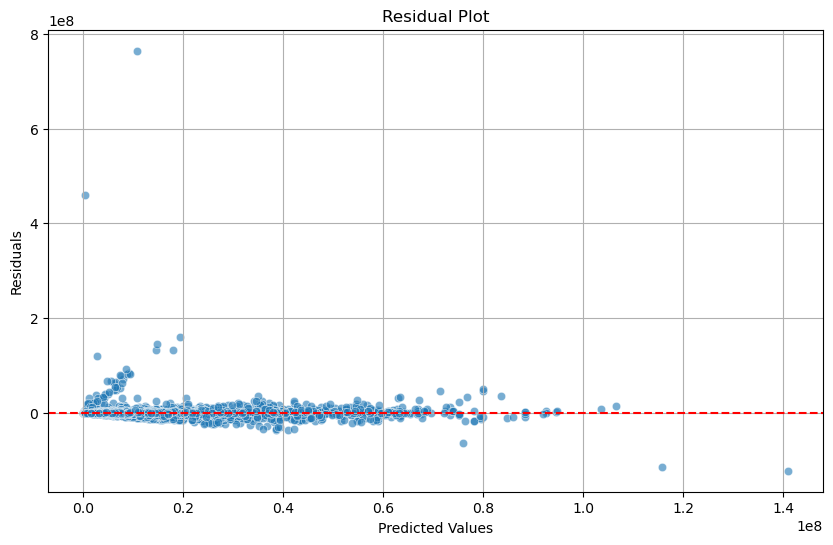

In [21]:
#Residual Plot
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')  # Horizontal line at 0
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


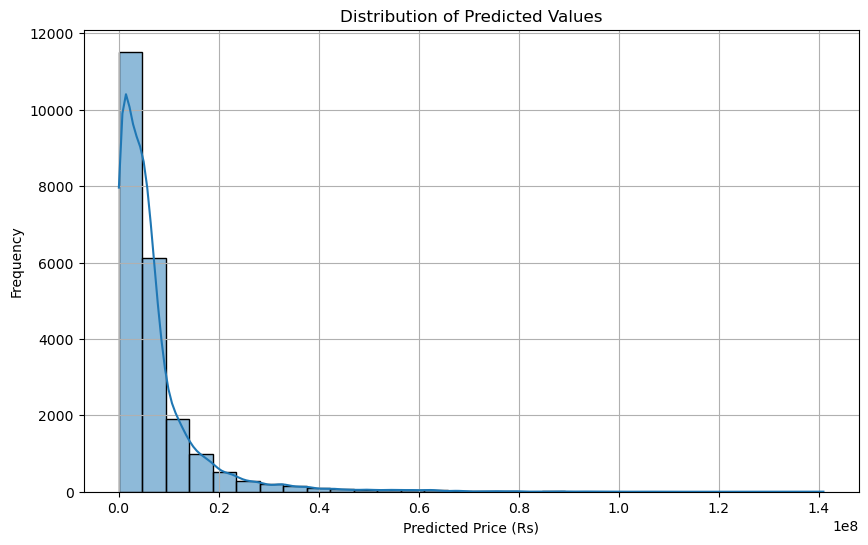

In [22]:
#Prediction Distribution Plot
# Plot distribution of predicted values
plt.figure(figsize=(10, 6))
sns.histplot(y_pred, kde=True, bins=30)
plt.title('Distribution of Predicted Values')
plt.xlabel('Predicted Price (Rs)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


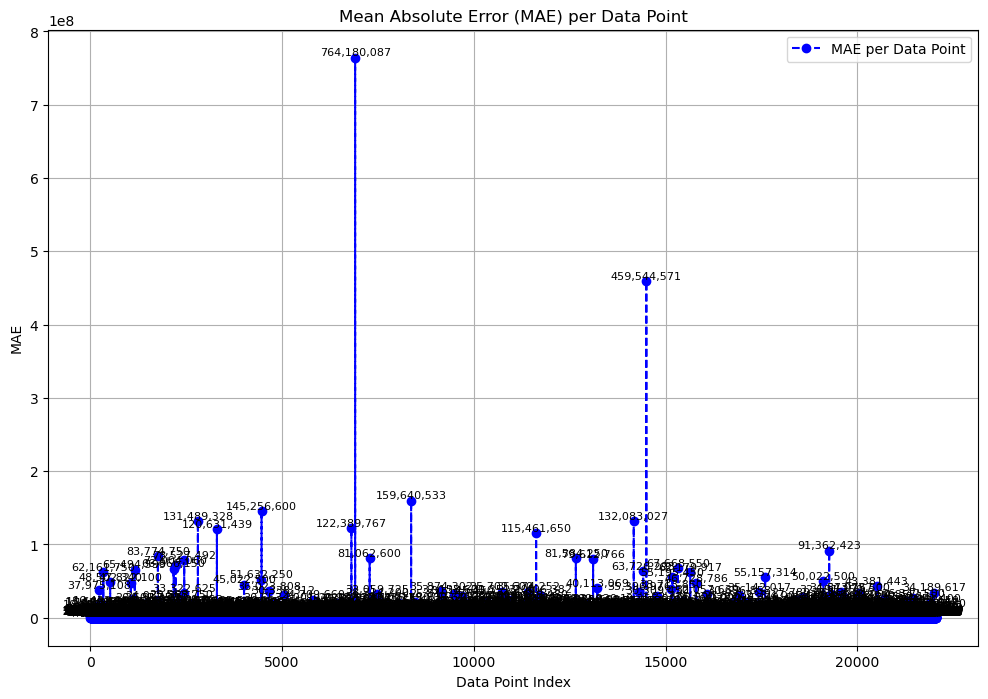

In [23]:
import matplotlib.pyplot as plt

# Calculate errors
errors = y_test - y_pred
mae_per_point = abs(errors)

# Plot MAE for each data point
plt.figure(figsize=(12, 8))

# Plot actual MAE values
plt.plot(mae_per_point.values, marker='o', linestyle='--', color='blue', label='MAE per Data Point')

# Annotate MAE values on the plot
for i, value in enumerate(mae_per_point.values):
    plt.text(i, value, f'{value:,.0f}', fontsize=8, ha='center', va='bottom')

plt.title('Mean Absolute Error (MAE) per Data Point')
plt.xlabel('Data Point Index')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()
plt.show()


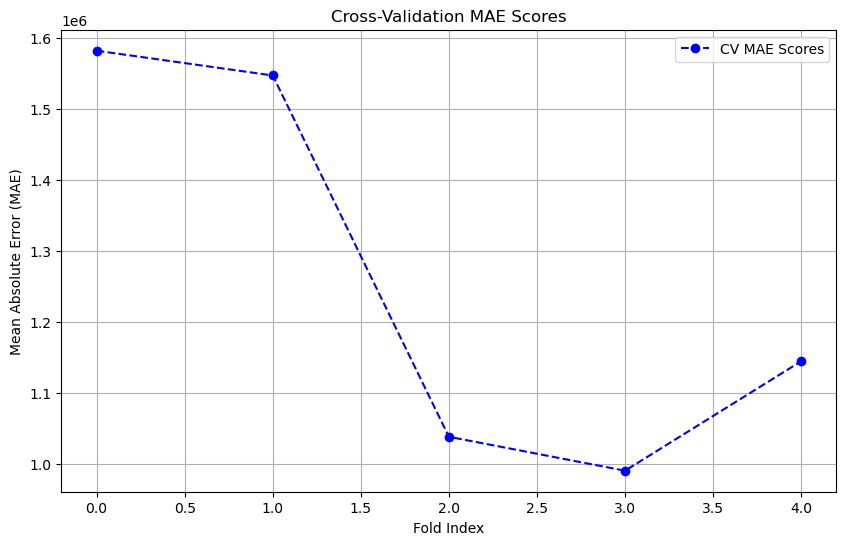

Average MAE from Cross-Validation: 1,260,482.91
Standard Deviation of MAE from Cross-Validation: 253,151.72


In [24]:
import numpy as np
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

# Convert negative MAE scores to positive for easier interpretation
cv_scores = -cv_scores

# Plot cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(cv_scores, marker='o', linestyle='--', color='blue', label='CV MAE Scores')  # Corrected linestyle
plt.title('Cross-Validation MAE Scores')
plt.xlabel('Fold Index')
plt.ylabel('Mean Absolute Error (MAE)')
plt.grid(True)
plt.legend()
plt.show()

# Print average and standard deviation of cross-validation scores
print(f'Average MAE from Cross-Validation: {cv_scores.mean():,.2f}')
print(f'Standard Deviation of MAE from Cross-Validation: {cv_scores.std():,.2f}')


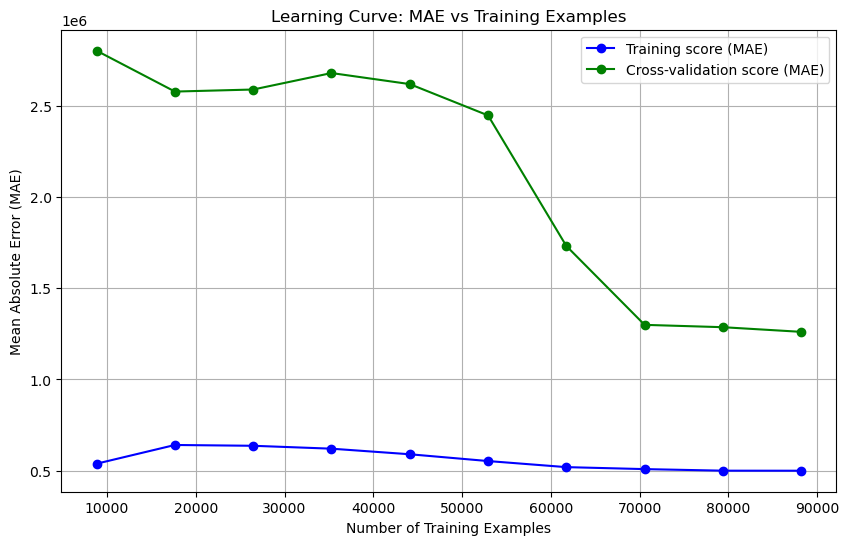

In [47]:
def plot_learning_curve(model, X, y, cv=5, scoring='neg_mean_absolute_error'):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, 
                                                            cv=cv, 
                                                            scoring=scoring, 
                                                            train_sizes=np.linspace(0.1, 1.0, 10), 
                                                            random_state=42)

    # Convert negative MAE (because of neg_mean_absolute_error) to positive values
    train_scores_mean = -train_scores.mean(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label="Training score (MAE)")
    plt.plot(train_sizes, test_scores_mean, 'o-', color='green', label="Cross-validation score (MAE)")

    plt.title("Learning Curve: MAE vs Training Examples")
    plt.xlabel("Number of Training Examples")
    plt.ylabel("Mean Absolute Error (MAE)")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

plot_learning_curve(model, X, y, cv=5)
